## Calibrating Camera

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

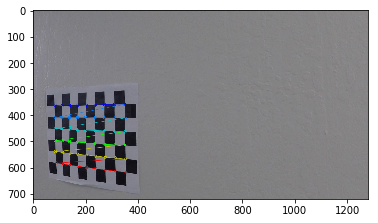

In [2]:
objpoints = []
imgpoints = []
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

for i in range(1,21):
    source = './camera_cal/calibration'+str(i)+'.jpg'
    img = mpimg.imread(source)
    plt.imshow(img)

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # FInd the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # if corents are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # draw and display the corners(
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

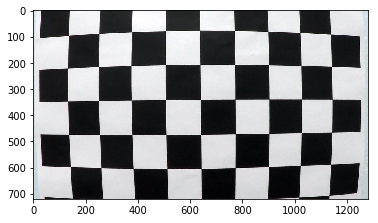

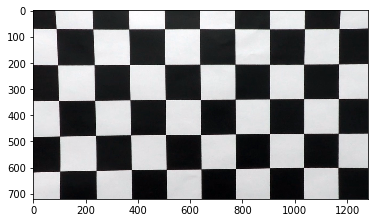

In [3]:
exp = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (exp.shape[1], exp.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)
dst = cv2.undistort(exp, mtx, dist, None, mtx)
plt.figure(1)
plt.imshow(exp)
plt.figure(2)
plt.imshow(dst)

In [4]:
def undist(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [5]:
# define source and destination points for transform
src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])

dst = np.float32([(450,0),
                  (img_size[0]-450,0),
                  (450,img_size[1]),
                  (img_size[0]-450,img_size[1])])

Minv = cv2.getPerspectiveTransform(dst,src)
M = cv2.getPerspectiveTransform(src, dst)

def warping(img, unwarping=True):
    img_size = (img.shape[1],img.shape[0])
    return cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)

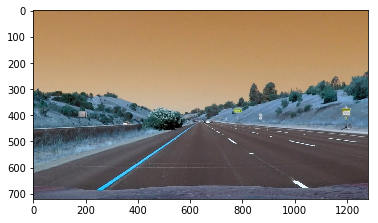

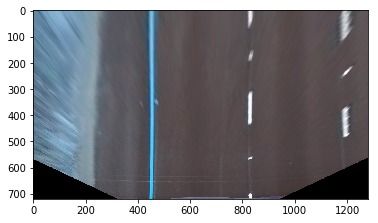

In [6]:
warp_exp = cv2.imread('./test_images/straight_lines1.jpg')
warped = warping(warp_exp)
plt.figure(1)
plt.imshow(warp_exp)
plt.figure(2)
plt.imshow(warped)

In [7]:
def pipeline(img, s_thresh=(120, 255), sx_thresh=(100, 255),l_thresh=(40,255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold xy gradient
    sxybinary = np.zeros_like(scaled_sobel)
    sxybinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
     # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    combined = np.zeros_like(sxbinary)
    combined[(l_binary == 1) & (s_binary == 1) | (sxbinary == 1)] = 1
    return combined

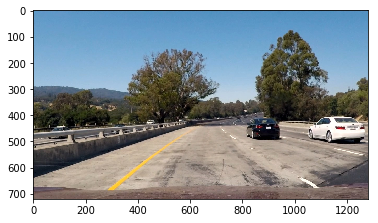

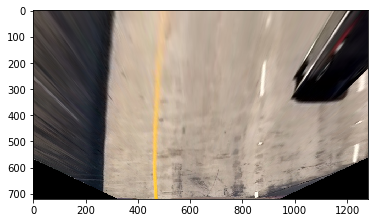

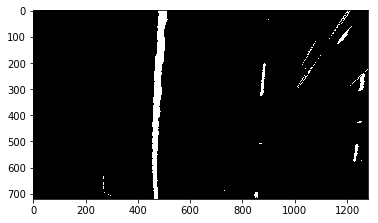

In [8]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
warped = warping(img)
plt.figure(1)
plt.imshow(img)
plt.figure(2)
plt.imshow(warped)
plt.figure(3)
binary_warped = pipeline(warped)
plt.imshow(binary_warped, cmap='gray')

## Sliding window

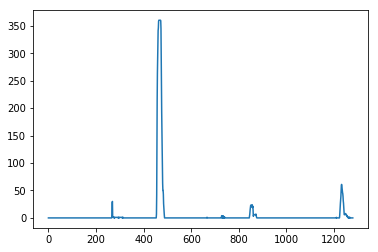

In [9]:
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)

In [10]:
def slidingWindow(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    left_rectangles = []
    right_rectangles = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        left_rectangles.append((win_xleft_low,win_y_low, win_xleft_high, win_y_high)) 
        right_rectangles.append((win_xright_low,win_y_low, win_xright_high,win_y_high)) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    plotRects = (left_rectangles, right_rectangles)
    return left_fit, right_fit, left_lane_inds, right_lane_inds, plotRects

### Testing the sliding window function

(720, 0)

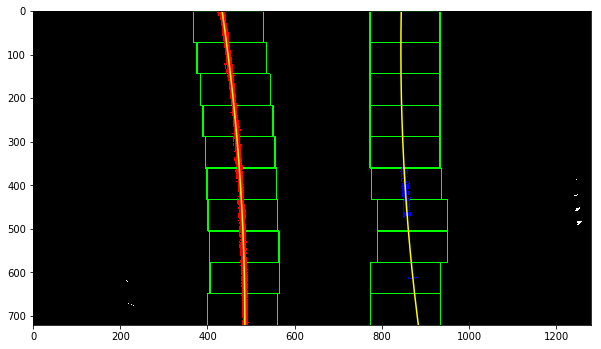

In [11]:
img = cv2.imread('./test_images/test2.jpg')
warped = warping(img)
binary_warped = pipeline(warped)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
left_fit, right_fit, left_lane_inds, right_lane_inds, plotRects = slidingWindow(binary_warped)

lefRects = plotRects[0]
rightRects = plotRects[1]

for rect in lefRects:
    cv2.rectangle(out_img,(rect[0] , rect[1]),(rect[2], rect[3]),
        (0,255,0), 2) 
    
for rect in rightRects:
    cv2.rectangle(out_img,(rect[0] , rect[1]),(rect[2], rect[3]),
        (0,255,0), 2)

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])    
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure(figsize=(10, 10))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [12]:
def laneWithwindow(binary_warped, left_fit, right_fit):  
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_new = np.polyfit(lefty, leftx, 2)
    right_fit_new = np.polyfit(righty, rightx, 2)
    
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

(720, 0)

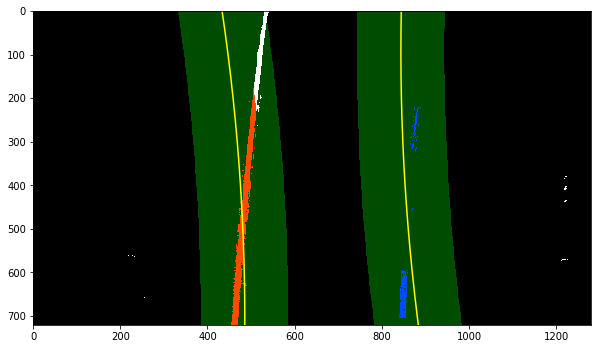

In [13]:
img = cv2.imread('./test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
warped = warping(img)
binary_warped = pipeline(warped)

left_fit_new, right_fit_new, left_lane_inds, right_lane_inds = laneWithwindow(binary_warped, left_fit, right_fit)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img2 = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img2 = np.zeros_like(out_img)
# Color in left and right line pixels
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])   
out_img2[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img2[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

margin = 100
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img2, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img2, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img2, 1, window_img2, 0.3, 0)
plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [14]:
def curvature(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    h = binary_warped.shape[0]
    ploty = np.linspace(0, h-1, h)
    ploty = np.linspace(0, 719, num=720)
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculating the offset
    pos = binary_warped.shape[1]/2
    left0 = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right0 = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    center = (left0 + right0) / 2.0
    offset = (pos - center) * xm_per_pix
    
    return left_curverad, right_curverad, offset

### Testing the curvature and offset calculation function

In [15]:
img = cv2.imread('./test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
warped = warping(img)
binary_warped = pipeline(warped)
left_fit, right_fit, left_lane_inds, right_lane_inds = laneWithwindow(binary_warped, left_fit, right_fit)
left_curverad, right_curverad, offset = curvature(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)
    
print(left_curverad, right_curverad, offset)    

1598.62005964 3486.77985624 -0.0141530777442


In [16]:
def addDrawing(original, warped, left_fit, right_fit):
    # Create an image to draw the lines on
    undist = np.copy(original)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    h = binary_warped.shape[0]
    ploty = np.linspace(0, h-1, h)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original.shape[1], original.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result        

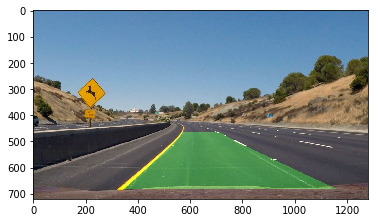

In [17]:
img = cv2.imread('./test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
warped = warping(img)
binary_warped = pipeline(warped)
left_fit, right_fit, left_lane_inds, right_lane_inds = laneWithwindow(binary_warped, left_fit, right_fit)
reimage = addDrawing(img, binary_warped, left_fit, right_fit)
plt.imshow(reimage)

In [18]:
def addText(original, rad, offset):
    undist = np.copy(original)
    h = undist.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius of Curvature = ' + '{:04.2f}'.format(rad) + '(m)'
    cv2.putText(undist, text, (40,60), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    LR = ''
    if offset > 0:
        LR = 'right'
    elif offset < 0:
        LR = 'left'
    text = 'Vehecle is ' + '{:04.2f}'.format(abs(offset)) + 'm ' + LR + ' of center'
    cv2.putText(undist, text, (40,120), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    return undist

In [19]:

class Line():
    nn=0
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def update(self, fit, inds):
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
                self.diffs[1] > 1 or \
                self.diffs[2] > 100.) and \
                len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit) - 5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

In [20]:
def addLineWarped(warped, left_fit, right_fit): 
    imcopy = np.copy(warped)
    # Recast the x and y points into usable format for cv2.fillPoly()
    h = binary_warped.shape[0]
    ploty = np.linspace(0, h-1, h)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])

    # Draw the lane onto the warped blank image
    cv2.polylines(imcopy, np.int_(pts_left), 0, (255, 0, 0), thickness=5)
    cv2.polylines(imcopy, np.int_(pts_right), 0, (255, 0, 0), thickness=5)

    return imcopy

In [21]:
def imageProcess(original):
    image = np.copy(original)
    binary = pipeline(image)
    warped = warping(image)
    binary_warped = warping(binary)
    
    if left_line.detected and right_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds = laneWithwindow(binary_warped, left_line.best_fit, right_line.best_fit)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds, plotRects = slidingWindow(binary_warped)
    
    if left_fit is not None and right_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = image.shape[0]
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            left_fit = None
            right_fit = None 
    
    left_line.update(left_fit, left_lane_inds)
    right_line.update(right_fit, right_lane_inds)
 
    if left_line.best_fit is not None and right_line.best_fit is not None:
        reimage = addDrawing(image, binary_warped, left_line.best_fit, right_line.best_fit)
        left_curverad, right_curverad, offset = curvature(binary_warped, left_line.best_fit, right_line.best_fit, left_lane_inds, right_lane_inds)
        outimage = addText(reimage, (left_curverad+right_curverad)/2., offset)
        warped_line = addLineWarped(warped, left_line.best_fit, right_line.best_fit)
    else:
        outimg = image
    
    ## assembeling output image
    outimg=np.zeros((576,1280,3), dtype=np.uint8)
    outimg[0:576,0:1024,:] =cv2.resize(outimage,(1024,576))
    #b) Threshold
    outimg[0:288,1024:1280, 0] =cv2.resize(binary*255,(256,288))
    outimg[0:288,1024:1280, 1] =cv2.resize(binary*255,(256,288))
    outimg[0:288,1024:1280, 2] =cv2.resize(binary*255,(256,288))
    #c)Birds eye view fitting
    outimg[310:576,1024:1280,:] =cv2.resize(warped_line,(256,266))
    
    cv2.putText(outimg, "Thresh", (1100,30), cv2.FONT_HERSHEY_DUPLEX, .8,(200,200,0), 1,  lineType = cv2.LINE_AA)
    cv2.putText(outimg, "Birds-eye fit", (1080,305), cv2.FONT_HERSHEY_DUPLEX, .8,(200,200,0), 1,  lineType = cv2.LINE_AA)
        
    return outimg

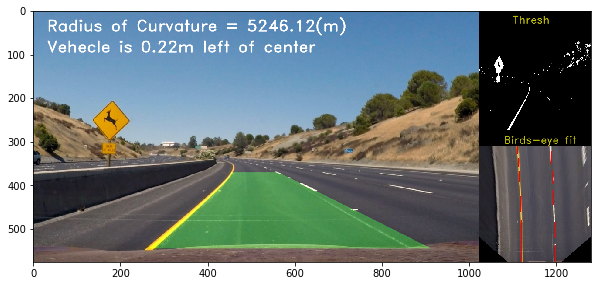

In [22]:

left_line = Line()
right_line = Line()

img = cv2.imread('./test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
processed_image = imageProcess(img)
plt.figure(figsize=(10, 10))
plt.imshow(processed_image)

In [23]:
from moviepy.editor import VideoFileClip

left_line = Line()
right_line = Line()
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(imageProcess)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:52<00:00,  5.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 32s, sys: 59.9 s, total: 5min 32s
Wall time: 3min 54s
